In [1]:
# Cell 2: Import libraries and load dataset

import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from Hugging Face Hub
dataset = load_dataset("KisanVaani/agriculture-qa-english-only", split='train')

print(f"Total samples in dataset: {len(dataset)}")
print(dataset[0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.97M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22615 [00:00<?, ? examples/s]

Total samples in dataset: 22615
{'question': 'why is crop rotation important in farming?', 'answers': 'This helps to prevent soil erosion and depletion, and can also help to control pests and diseases'}


In [2]:
# Cell 3: Prepare train and validation splits using datasets library

split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

train_data = split_dataset['train']
val_data = split_dataset['test']

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


Training samples: 18092
Validation samples: 4523


In [3]:
# Cell 4: Load tokenizer and define preprocessing

MODEL_NAME = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

MAX_LEN_INPUT = 64
MAX_LEN_OUTPUT = 64

def shift_tokens_right(input_ids, pad_token_id, decoder_start_token_id):
    shifted_input_ids = np.zeros_like(input_ids)
    shifted_input_ids[:, 0] = decoder_start_token_id
    shifted_input_ids[:, 1:] = input_ids[:, :-1]
    shifted_input_ids[input_ids == pad_token_id] = pad_token_id
    return shifted_input_ids.tolist()

def preprocess_function(examples):
    inputs = ["question: " + q for q in examples["question"]]
    targets = examples["answers"]  # or 'answer' based on your dataset
    model_inputs = tokenizer(inputs, max_length=MAX_LEN_INPUT, truncation=True, padding="max_length")

    labels = tokenizer(targets, max_length=MAX_LEN_OUTPUT, truncation=True, padding="max_length")
    labels_ids = labels["input_ids"]

    labels_ids = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in labels_ids]
    model_inputs["labels"] = labels_ids

    decoder_input_ids = shift_tokens_right(
        np.array(labels["input_ids"]),
        pad_token_id=tokenizer.pad_token_id,
        decoder_start_token_id=tokenizer.pad_token_id
    )
    model_inputs["decoder_input_ids"] = decoder_input_ids

    return model_inputs

train_dataset = train_data.map(preprocess_function, batched=True)
val_dataset = val_data.map(preprocess_function, batched=True)

train_dataset.set_format(type="tensorflow", columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
val_dataset.set_format(type="tensorflow", columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/18092 [00:00<?, ? examples/s]

Map:   0%|          | 0/4523 [00:00<?, ? examples/s]

In [4]:
# Cell 5: Convert Hugging Face datasets to tf.data.Dataset, including decoder_input_ids

def to_tf_dataset(hf_dataset):
    features = {
        "input_ids": np.array(hf_dataset["input_ids"]),
        "attention_mask": np.array(hf_dataset["attention_mask"]),
        "decoder_input_ids": np.array(hf_dataset["decoder_input_ids"]),
    }
    labels = np.array(hf_dataset["labels"])
    return tf.data.Dataset.from_tensor_slices((features, labels))

batch_size = 8  # Adjust this based on your CPU resources

tf_train_dataset = to_tf_dataset(train_dataset).shuffle(100).batch(batch_size)
tf_val_dataset = to_tf_dataset(val_dataset).batch(batch_size)

print("Training dataset batches:", tf_train_dataset)
print("Validation dataset batches:", tf_val_dataset)


Training dataset batches: <_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>
Validation dataset batches: <_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>


In [5]:
# Cell 6: Load model and compile

model = TFT5ForConditionalGeneration.from_pretrained(MODEL_NAME, from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

def masked_loss(y_true, y_pred):
    pad_token_id = tf.constant(tokenizer.pad_token_id, dtype=y_true.dtype)
    y_true_safe = tf.where(y_true == -100, pad_token_id, y_true)
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(y_true_safe, y_pred, from_logits=True)
    mask = tf.cast(tf.not_equal(y_true, -100), dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


model.compile(optimizer=optimizer, loss=masked_loss)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/3
2262/2262 [==============================] - 314s 120ms/step - loss: 2.5111 - val_loss: 1.2058
Epoch 2/3
2262/2262 [==============================] - 255s 113ms/step - loss: 1.2682 - val_loss: 0.5301
Epoch 3/3
2262/2262 [==============================] - 256s 113ms/step - loss: 0.7364 - val_loss: 0.3525


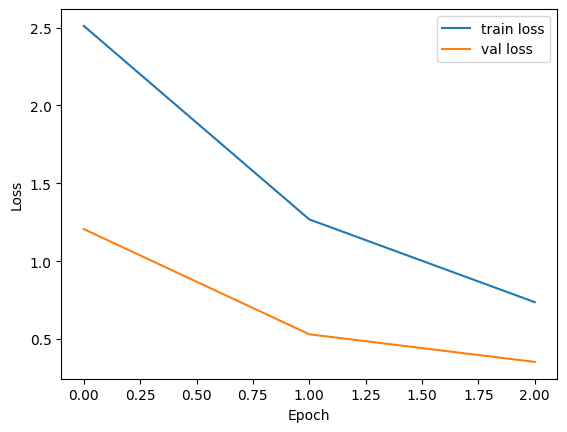

In [6]:
# Cell 7: Train model

epochs = 3

history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=epochs)

# Plot training/validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Cell 8: Save model and tokenizer

model.save_pretrained("./agri_chatbot_t5")
tokenizer.save_pretrained("./agri_chatbot_t5")


In [ ]:
# Cell 9: Define inference function and test

def generate_answer(question, max_length=64):
    input_text = "question: " + question
    input_ids = tokenizer.encode(input_text, return_tensors="tf", max_length=MAX_LEN_INPUT, truncation=True, padding="max_length")
    outputs = model.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

test_question = "What is necessary to facilitate seedling growth during the germination process?"
print("Q:", test_question)
print("A:", generate_answer(test_question))


In [9]:
%%writefile app.py
import streamlit as st
from transformers import T5Tokenizer, TFT5ForConditionalGeneration

MODEL_PATH = "./agri_chatbot_t5"

@st.cache_resource
def load_model():
    tokenizer = T5Tokenizer.from_pretrained(MODEL_PATH)
    model = TFT5ForConditionalGeneration.from_pretrained(MODEL_PATH, from_pt=True)
    return tokenizer, model

tokenizer, model = load_model()

def generate_answer(question, max_length=64):
    input_text = "question: " + question
    input_ids = tokenizer.encode(input_text, return_tensors="tf", truncation=True, padding="max_length", max_length=64)
    outputs = model.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

st.title("🌱 Agriculture Chatbot - T5")
st.write("Ask any question about agriculture and get accurate responses!")

user_input = st.text_input("Enter your question:")

if st.button("Get Answer"):
    if user_input.strip():
        answer = generate_answer(user_input)
        st.success(f"Answer: {answer}")
    else:
        st.warning("Please enter a valid question.")


Writing app.py


In [10]:
question = "what is fertilizers?"
answer = generate_answer(question)
print("Q:", question)
print("A:", answer)


Q: what is fertilizers?
A: Fertilizers are substances that are added to soil to improve the growth and quality of crops
